In [1]:
!pip install ucimlrepo
!pip install libsvm-official

  Preparing metadata (setup.py) ... done
  Created wheel for libsvm-official: filename=libsvm_official-3.32.0-cp310-cp310-linux_x86_64.whl size=123883 sha256=d609a57404887c972eaf5334c6632592f7e466faf2372e329a4abddba62e3be7
  Stored in directory: /root/.cache/pip/wheels/61/3b/1b/73bb4869517f96a26c82b47ccdb9ec48f12f4466de2371eff6
Successfully built libsvm-official


/usr/local/lib/python3.10/dist-packages/libsvm/svm.py:147: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def csr_to_problem_jit(l, x_val, x_ind, x_rowptr, prob_val, prob_ind, prob_rowptr, indx_start):


Streaming output truncated to the last 5000 lines.
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accuracy = 88.6364%
Cross Validation Accuracy = 76.1364%
Cross Validation Accurac

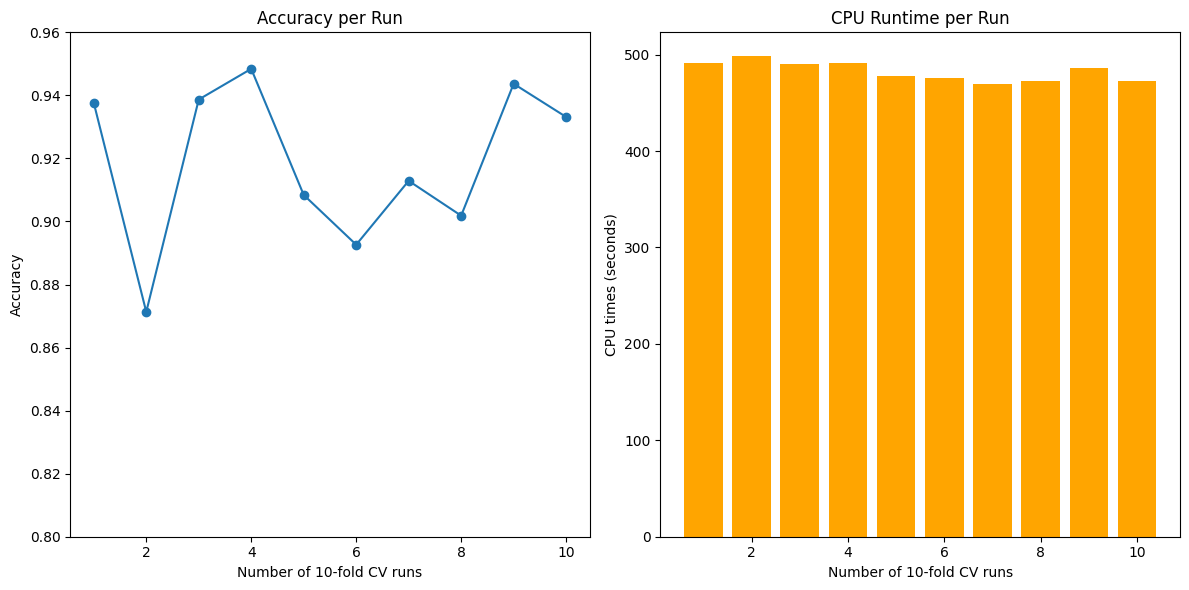

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from libsvm.svmutil import *
from ucimlrepo import fetch_ucirepo

np.random.seed(seed=42)

class FOASVM:
    def __init__(self, population_size=8, max_iterations=250, ax=20, bx=10, ay=20, by=10):
        self.population_size = population_size
        self.max_iterations = max_iterations
        self.ax = ax
        self.bx = bx
        self.ay = ay
        self.by = by

    def initialize_population(self):
        self.X_axis = np.random.uniform(-1, 1, 2)
        self.Y_axis = np.random.uniform(-1, 1, 2)

    def smell_concentration(self, C, gamma, X, y):
        prob = svm_problem(y.tolist(), X.tolist())
        param = svm_parameter(f'-s 0 -t 2 -c {C} -g {gamma} -v 5')
        score = svm_train(prob, param)
        return score / 100  # Convert percentage to fraction

    def search(self, X, y):
        best_score = -np.inf
        best_C = 0
        best_gamma = 0

        for _ in range(self.max_iterations):
            X_pos = self.X_axis + self.ax * np.random.rand(self.population_size, 2) - self.bx
            Y_pos = self.Y_axis + self.ay * np.random.rand(self.population_size, 2) - self.by

            D = np.sqrt(X_pos**2 + Y_pos**2)
            S = 1 / D

            for i in range(self.population_size):
                C = 2**np.clip(S[i, 0] * 20 - 5, -5, 15)
                gamma = 2**np.clip(S[i, 1] * 15 - 15, -15, 1)

                score = self.smell_concentration(C, gamma, X, y)

                if score > best_score:
                    best_score = score
                    best_C = C
                    best_gamma = gamma
                    self.X_axis = X_pos[i]
                    self.Y_axis = Y_pos[i]

        return best_C, best_gamma, best_score

    def fit(self, X, y):
        self.X = X
        self.y = y
        scaler = MinMaxScaler(feature_range=(-1, 1))
        self.X = scaler.fit_transform(self.X)

        outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
        all_outer_scores = []
        all_auc_scores = []
        all_sensitivity_scores = []
        all_specificity_scores = []
        all_run_times = []

        for _ in range(10):  # Repeat the 10-fold CV procedure 10 times
            outer_scores = []
            auc_scores = []
            sensitivity_scores = []
            specificity_scores = []
            fold_run_times = []
            
            for train_index, test_index in outer_cv.split(self.X):
                start_time = time.time()
                
                X_train, X_test = self.X[train_index], self.X[test_index]
                y_train, y_test = self.y[train_index], self.y[test_index]

                self.initialize_population()
                best_C, best_gamma, _ = self.search(X_train, y_train)

                prob = svm_problem(y_train.tolist(), X_train.tolist())
                param = svm_parameter(f'-s 0 -t 2 -c {best_C} -g {best_gamma} -b 1')
                model = svm_train(prob, param)

                p_label, p_acc, p_val = svm_predict(y_test.tolist(), X_test.tolist(), model, '-b 1')
                
                end_time = time.time()
                fold_run_times.append(end_time - start_time)
                
                score = p_acc[0] / 100  # Accuracy
                outer_scores.append(score)

                # Calculate AUC from probability estimates
                positive_class_index = 0  # class 0 is healthy (positive class)
                positive_probabilities = [val[positive_class_index] for val in p_val]  # Extract probability of positive class
                auc = roc_auc_score(y_test, positive_probabilities)
                auc_scores.append(auc)

                # Calculate sensitivity and specificity
                tn, fp, fn, tp = confusion_matrix(y_test, p_label).ravel()
                sensitivity = tp / (tp + fn)
                specificity = tn / (tn + fp)

                sensitivity_scores.append(sensitivity)
                specificity_scores.append(specificity)

            all_outer_scores.extend(outer_scores)
            all_auc_scores.extend(auc_scores)
            all_sensitivity_scores.extend(sensitivity_scores)
            all_specificity_scores.extend(specificity_scores)
            all_run_times.append(np.sum(fold_run_times))
            
        mean_accuracy = np.mean(all_outer_scores)
        std_accuracy = np.std(all_outer_scores)
        mean_auc = np.mean(all_auc_scores)
        std_auc = np.std(all_auc_scores)
        mean_sensitivity = np.mean(all_sensitivity_scores)
        std_sensitivity = np.std(all_sensitivity_scores)
        mean_specificity = np.mean(all_specificity_scores)
        std_specificity = np.std(all_specificity_scores)

        return (mean_accuracy, std_accuracy, mean_auc, std_auc,
                mean_sensitivity, std_sensitivity, mean_specificity, std_specificity,
                all_run_times, all_outer_scores)

# Fetch dataset
parkinsons = fetch_ucirepo(id=174)

# Data
X = parkinsons.data.features.values
y = parkinsons.data.targets.values.ravel()

print(list(y).count(0))
print(list(y).count(1))

foa_svm = FOASVM()
(mean_accuracy, std_accuracy, mean_auc, std_auc,
 mean_sensitivity, std_sensitivity, mean_specificity, std_specificity,
 all_run_times, all_outer_scores) = foa_svm.fit(X, y)

print(f'Mean accuracy: {mean_accuracy:.4f}')
print(f'Standard deviation of accuracy: {std_accuracy:.4f}')
print(f'Mean AUC: {mean_auc:.4f}')
print(f'Standard deviation of AUC: {std_auc:.4f}')
print(f'Mean sensitivity: {mean_sensitivity:.4f}')
print(f'Standard deviation of sensitivity: {std_sensitivity:.4f}')
print(f'Mean specificity: {mean_specificity:.4f}')
print(f'Standard deviation of specificity: {std_specificity:.4f}')

# Plotting accuracy and CPU runtime per run
plt.figure(figsize=(12, 6))

# Plot accuracy per run
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), [np.mean(all_outer_scores[i*10:(i+1)*10]) for i in range(10)], marker='o')
plt.title('Accuracy per Run')
plt.xlabel('Number of 10-fold CV runs')
plt.ylabel('Accuracy')
plt.ylim(0.80, 0.96)

# Plot CPU runtime per run as a bar chart
plt.subplot(1, 2, 2)
plt.bar(range(1, 11), all_run_times, color='orange')
plt.title('CPU Runtime per Run')
plt.xlabel('Number of 10-fold CV runs')
plt.ylabel('CPU times (seconds)')

plt.tight_layout()
plt.show()
